In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

a = tf.constant(0.)
b = 2 * a
g = tf.gradients(a + b, [a, b])
hello = tf.constant('Hello, TensorFlow!')

sess = tf.compat.v1.Session()
with tf.compat.v1.Session() as sess:
    print(sess.run(g))

[3.0, 1.0]


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Flatten, Dense, Conv2D, ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.98:
            # print('inside if')
            self.model.stop_training = True

    early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor="val_accuracy", 
      patience=16,
      mode="auto",
      min_delta=1
)

    filepath = '/content/drive/MyDrive/ModelResults/vgg-19-model-realworld.h5'
    checkpoint = ModelCheckpoint(
      filepath=filepath,
      monitor='val_accuracy',
      verbose=1,
      save_best_only=True,
      mode='max'
)

callback = MyCallback()

In [ ]:
# Load the dataset
data_path = '/content/drive/MyDrive/Dataset/AugmentRealWorld/Train'

train_datagen = ImageDataGenerator(rescale=1./255)
train_datagenerator = train_datagen.flow_from_directory(
    data_path,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size= 64
)

validation_data_path = '/content/drive/MyDrive/Dataset/AugmentRealWorld/Validation'

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_datagenerator = validation_datagen.flow_from_directory(
    validation_data_path,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size= 64
)

Found 3348 images belonging to 12 classes.
Found 1026 images belonging to 12 classes.


In [ ]:
def build_VGG16():
  model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

  len_layers = len(model.layers)
  for i, layer in enumerate(model.layers):
      if i == int(len_layers * 0.1):
          break
      layer.trainable = False
  Flat_layer = Flatten()(model.layers[-1].output)
  Dense_1 = Dense(1024, activation='relu')(Flat_layer)
  Output = Dense(12, activation='softmax')(Dense_1) 
  model = Model(inputs=model.inputs, outputs=Output)
  model.call = tf.function(model.call)
  model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    #run_eagerly = True
    ) 
  return model 

In [ ]:
model = build_VGG16()

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
history = model.fit(train_datagenerator,epochs=500, validation_data=validation_datagenerator, steps_per_epoch=16, callbacks=[callback])

Epoch 1/500
16/16 [==============================] - ETA: 0s - batch: 7.5000 - size: 64.0000 - loss: 10.5486 - accuracy: 0.1221 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


16/16 [==============================] - 542s 32s/step - batch: 7.5000 - size: 64.0000 - loss: 10.5486 - accuracy: 0.1221 - val_loss: 2.4352 - val_accuracy: 0.1979
Epoch 2/500
16/16 [==============================] - 96s 6s/step - batch: 7.5000 - size: 64.0000 - loss: 2.3962 - accuracy: 0.1699 - val_loss: 2.4101 - val_accuracy: 0.1988
Epoch 3/500
16/16 [==============================] - 250s 16s/step - batch: 7.5000 - size: 61.2500 - loss: 2.3963 - accuracy: 0.1418 - val_loss: 2.3831 - val_accuracy: 0.2534
Epoch 4/500
16/16 [==============================] - 105s 7s/step - batch: 7.5000 - size: 61.2500 - loss: 2.3285 - accuracy: 0.2480 - val_loss: 2.4115 - val_accuracy: 0.1852
Epoch 5/500
16/16 [==============================] - 32s 2s/step - batch: 7.5000 - size: 64.0000 - loss: 2.2460 - accuracy: 0.2598 - val_loss: 2.2724 - val_accuracy: 0.2622
Epoch 6/500
16/16 [==============================] - 30s 2s/step - batch: 7.5000 - size: 64.0000 - loss: 2.1815 - accuracy: 0.2920 - val_loss

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
test_data_path = '/content/drive/MyDrive/Dataset/AugmentRealWorld/Test'

test_datagen = ImageDataGenerator(rescale=1./255)
test_datagenerator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(224, 224),
    class_mode='categorical',
    batch_size= 64
)

Found 721 images belonging to 12 classes.


In [ ]:
#Get the accuracy score

test_score = model.evaluate_generator(test_datagenerator)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100)) 

print("[INFO] Loss: ",test_score[0])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training_v1.py:1273: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[INFO] accuracy: 66.85%
[INFO] Loss:  2.3952517608801522


In [ ]:
layer_outputs = [layer.output for layer in model.layers[:-1]] 

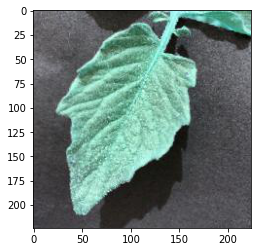

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

orig_img = np.array(load_img('/content/drive/MyDrive/Dataset/AugmentRealWorld/Train/healthy/sls_0_1884.jpeg'),dtype=np.uint8)
plt.imshow(orig_img)
plt.show()

In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/scorecamutil.py' .

In [ ]:
tf.keras.models.save_model(
    model,
    './trained_model_vgg_scorecam.h5',
    overwrite=True,
    include_optimizer=True
)

/content/scorecamutil.py:41: RuntimeWarning: invalid value encountered in true_divide
  cam /= np.max(cam)  # scale 0 to 1.0
/content/scorecamutil.py:67: RuntimeWarning: invalid value encountered in true_divide
  alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/

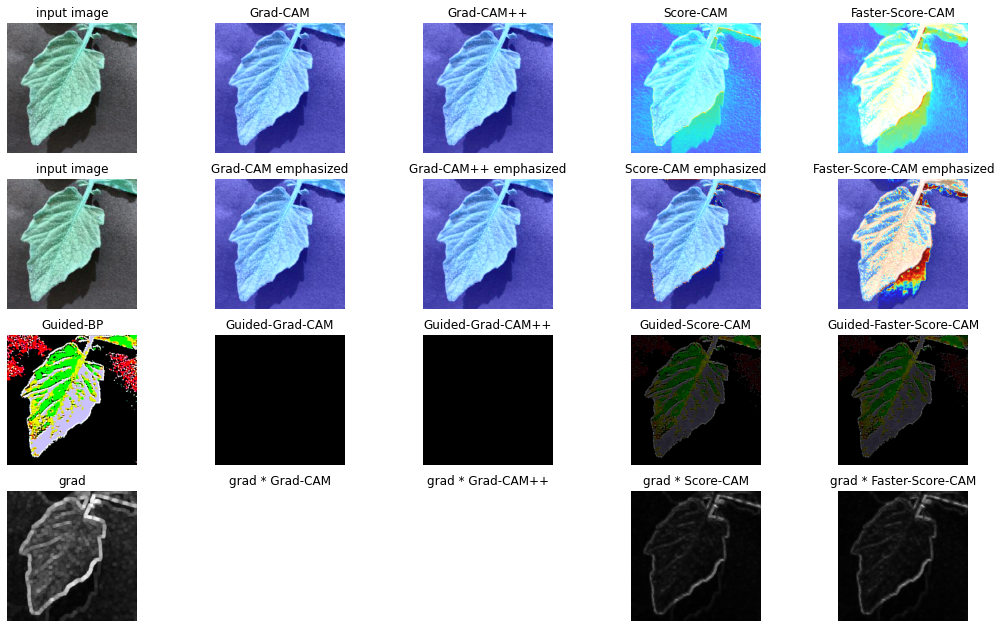

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scorecamutil import GradCam, GradCamPlusPlus, ScoreCam, build_guided_model, GuidedBackPropagation, superimpose, read_and_preprocess_img

def build_Sequential_and_load():
    model = build_VGG16()
    model.load_weights('/content/trained_model_vgg_scorecam.h5')
    return model

img_path = '/content/drive/MyDrive/Dataset/AugmentRealWorld/Train/healthy/sls_0_1884.jpeg'
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(224,224))

layer_name = 'block1_conv1'

# predictions = model.predict(img_array)
# top = decode_predictions(predictions, top=5)[0]
# print(img_path)
# print("class activation map for:",top[0])

grad_cam=GradCam(model,img_array,layer_name)
grad_cam_superimposed = superimpose(img_path, grad_cam)
grad_cam_emphasized = superimpose(img_path, grad_cam, emphasize=True)

grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)
grad_cam_plus_plus_emphasized = superimpose(img_path, grad_cam_plus_plus, emphasize=True)

score_cam=ScoreCam(model,img_array,layer_name)
score_cam_superimposed = superimpose(img_path, score_cam)
score_cam_emphasized = superimpose(img_path, score_cam, emphasize=True)

faster_score_cam=ScoreCam(model,img_array,layer_name, max_N=10)
faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)

guided_model = build_guided_model(build_Sequential_and_load)
saliency = GuidedBackPropagation(guided_model, img_array, layer_name)
saliency_resized = cv2.resize(saliency, (orig_img.shape[1], orig_img.shape[0]))

grad_cam_resized = cv2.resize(grad_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_grad_cam = saliency_resized * grad_cam_resized[..., np.newaxis]

grad_cam_plus_plus_resized = cv2.resize(grad_cam_plus_plus, (orig_img.shape[1], orig_img.shape[0]))
guided_grad_cam_plus_plus = saliency_resized * grad_cam_plus_plus_resized[..., np.newaxis]

score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_score_cam = saliency_resized * score_cam_resized[..., np.newaxis]

faster_score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_faster_score_cam = saliency_resized * faster_score_cam_resized[..., np.newaxis]

img_gray = cv2.imread(img_path, 0)
dx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
dy = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
grad = np.sqrt(dx ** 2 + dy ** 2)  # 画像の勾配を取得
grad = cv2.dilate(grad,kernel=np.ones((5,5)), iterations=1)  # 太らせる処理
grad -= np.min(grad)
grad /= np.max(grad)  # scale 0. to 1.

grad_times_grad_cam = grad * grad_cam_resized
grad_times_grad_cam_plus_plus = grad * grad_cam_plus_plus_resized
grad_times_score_cam = grad * score_cam_resized
grad_times_faster_score_cam = grad * faster_score_cam_resized

fig, ax = plt.subplots(nrows=4,ncols=5, figsize=(18, 11))
ax[0,0].imshow(orig_img)
ax[0,0].set_title("input image")
ax[0,1].imshow(grad_cam_superimposed)
ax[0,1].set_title("Grad-CAM")
ax[0,2].imshow(grad_cam_plus_plus_superimposed)
ax[0,2].set_title("Grad-CAM++")
ax[0,3].imshow(score_cam_superimposed)
ax[0,3].set_title("Score-CAM")
ax[0,4].imshow(faster_score_cam_superimposed)
ax[0,4].set_title("Faster-Score-CAM")
ax[1,0].imshow(orig_img)
ax[1,0].set_title("input image")
ax[1,1].imshow(grad_cam_emphasized)
ax[1,1].set_title("Grad-CAM emphasized")
ax[1,2].imshow(grad_cam_plus_plus_emphasized)
ax[1,2].set_title("Grad-CAM++ emphasized")
ax[1,3].imshow(score_cam_emphasized)
ax[1,3].set_title("Score-CAM emphasized")
ax[1,4].imshow(faster_score_cam_emphasized)
ax[1,4].set_title("Faster-Score-CAM emphasized")
ax[2,0].imshow(saliency_resized)
ax[2,0].set_title("Guided-BP")
ax[2,1].imshow(guided_grad_cam)
ax[2,1].set_title("Guided-Grad-CAM")
ax[2,2].imshow(guided_grad_cam_plus_plus)
ax[2,2].set_title("Guided-Grad-CAM++")
ax[2,3].imshow(guided_score_cam)
ax[2,3].set_title("Guided-Score-CAM")
ax[2,4].imshow(guided_faster_score_cam)
ax[2,4].set_title("Guided-Faster-Score-CAM")
ax[3,0].imshow(grad, 'gray')
ax[3,0].set_title("grad")
ax[3,1].imshow(grad_times_grad_cam, 'gray')
ax[3,1].set_title("grad * Grad-CAM")
ax[3,2].imshow(grad_times_grad_cam_plus_plus, 'gray')
ax[3,2].set_title("grad * Grad-CAM++")
ax[3,3].imshow(grad_times_score_cam, 'gray')
ax[3,3].set_title("grad * Score-CAM")
ax[3,4].imshow(grad_times_faster_score_cam, 'gray')
ax[3,4].set_title("grad * Faster-Score-CAM")
for i in range(4):
    for j in range(5):
        ax[i,j].axis('off')
plt.show()

/content/scorecamutil.py:41: RuntimeWarning: invalid value encountered in true_divide
  cam /= np.max(cam)  # scale 0 to 1.0
/content/scorecamutil.py:67: RuntimeWarning: invalid value encountered in true_divide
  alphas /= alpha_normalization_constant.reshape((1,1,conv_first_grad[0].shape[2]))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/

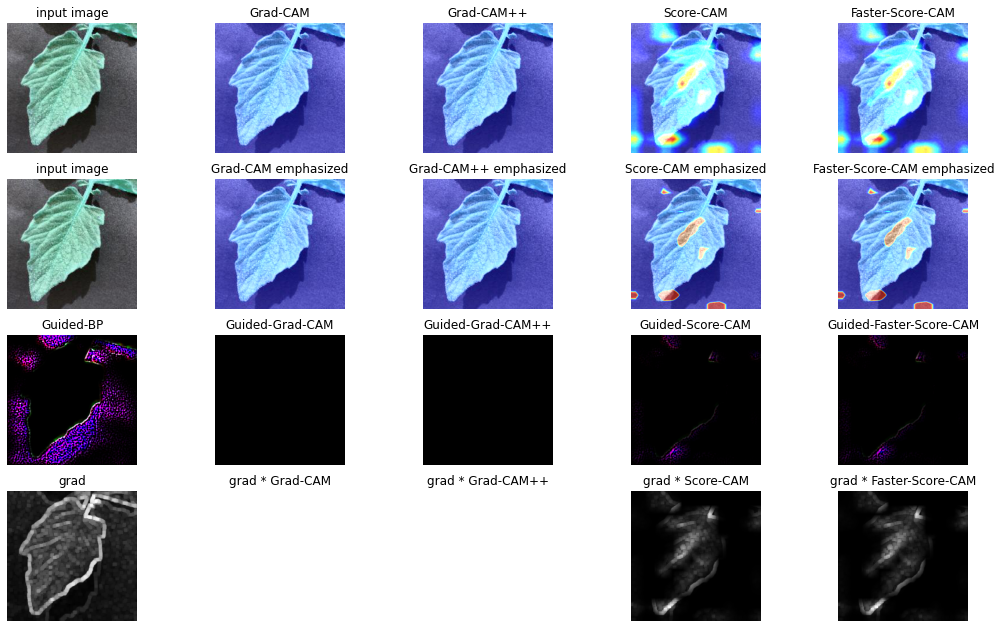

In [ ]:
def build_Sequential_and_load():
    model = build_VGG16()
    model.load_weights('/content/trained_model_vgg_scorecam.h5')
    return model

img_path = '/content/drive/MyDrive/Dataset/AugmentRealWorld/Train/healthy/sls_0_1884.jpeg'
orig_img = np.array(load_img(img_path),dtype=np.uint8)
img_array = read_and_preprocess_img(img_path, size=(224,224))

layer_name = 'block5_conv3'

# predictions = model.predict(img_array)
# top = decode_predictions(predictions, top=5)[0]
# print(img_path)
# print("class activation map for:",top[0])

grad_cam=GradCam(model,img_array,layer_name)
grad_cam_superimposed = superimpose(img_path, grad_cam)
grad_cam_emphasized = superimpose(img_path, grad_cam, emphasize=True)

grad_cam_plus_plus=GradCamPlusPlus(model,img_array,layer_name)
grad_cam_plus_plus_superimposed = superimpose(img_path, grad_cam_plus_plus)
grad_cam_plus_plus_emphasized = superimpose(img_path, grad_cam_plus_plus, emphasize=True)

score_cam=ScoreCam(model,img_array,layer_name)
score_cam_superimposed = superimpose(img_path, score_cam)
score_cam_emphasized = superimpose(img_path, score_cam, emphasize=True)

faster_score_cam=ScoreCam(model,img_array,layer_name, max_N=10)
faster_score_cam_superimposed = superimpose(img_path, faster_score_cam)
faster_score_cam_emphasized = superimpose(img_path, faster_score_cam, emphasize=True)

guided_model = build_guided_model(build_Sequential_and_load)
saliency = GuidedBackPropagation(guided_model, img_array, layer_name)
saliency_resized = cv2.resize(saliency, (orig_img.shape[1], orig_img.shape[0]))

grad_cam_resized = cv2.resize(grad_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_grad_cam = saliency_resized * grad_cam_resized[..., np.newaxis]

grad_cam_plus_plus_resized = cv2.resize(grad_cam_plus_plus, (orig_img.shape[1], orig_img.shape[0]))
guided_grad_cam_plus_plus = saliency_resized * grad_cam_plus_plus_resized[..., np.newaxis]

score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_score_cam = saliency_resized * score_cam_resized[..., np.newaxis]

faster_score_cam_resized = cv2.resize(score_cam, (orig_img.shape[1], orig_img.shape[0]))
guided_faster_score_cam = saliency_resized * faster_score_cam_resized[..., np.newaxis]

img_gray = cv2.imread(img_path, 0)
dx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
dy = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
grad = np.sqrt(dx ** 2 + dy ** 2)  # 画像の勾配を取得
grad = cv2.dilate(grad,kernel=np.ones((5,5)), iterations=1)  # 太らせる処理
grad -= np.min(grad)
grad /= np.max(grad)  # scale 0. to 1.

grad_times_grad_cam = grad * grad_cam_resized
grad_times_grad_cam_plus_plus = grad * grad_cam_plus_plus_resized
grad_times_score_cam = grad * score_cam_resized
grad_times_faster_score_cam = grad * faster_score_cam_resized

fig, ax = plt.subplots(nrows=4,ncols=5, figsize=(18, 11))
ax[0,0].imshow(orig_img)
ax[0,0].set_title("input image")
ax[0,1].imshow(grad_cam_superimposed)
ax[0,1].set_title("Grad-CAM")
ax[0,2].imshow(grad_cam_plus_plus_superimposed)
ax[0,2].set_title("Grad-CAM++")
ax[0,3].imshow(score_cam_superimposed)
ax[0,3].set_title("Score-CAM")
ax[0,4].imshow(faster_score_cam_superimposed)
ax[0,4].set_title("Faster-Score-CAM")
ax[1,0].imshow(orig_img)
ax[1,0].set_title("input image")
ax[1,1].imshow(grad_cam_emphasized)
ax[1,1].set_title("Grad-CAM emphasized")
ax[1,2].imshow(grad_cam_plus_plus_emphasized)
ax[1,2].set_title("Grad-CAM++ emphasized")
ax[1,3].imshow(score_cam_emphasized)
ax[1,3].set_title("Score-CAM emphasized")
ax[1,4].imshow(faster_score_cam_emphasized)
ax[1,4].set_title("Faster-Score-CAM emphasized")
ax[2,0].imshow(saliency_resized)
ax[2,0].set_title("Guided-BP")
ax[2,1].imshow(guided_grad_cam)
ax[2,1].set_title("Guided-Grad-CAM")
ax[2,2].imshow(guided_grad_cam_plus_plus)
ax[2,2].set_title("Guided-Grad-CAM++")
ax[2,3].imshow(guided_score_cam)
ax[2,3].set_title("Guided-Score-CAM")
ax[2,4].imshow(guided_faster_score_cam)
ax[2,4].set_title("Guided-Faster-Score-CAM")
ax[3,0].imshow(grad, 'gray')
ax[3,0].set_title("grad")
ax[3,1].imshow(grad_times_grad_cam, 'gray')
ax[3,1].set_title("grad * Grad-CAM")
ax[3,2].imshow(grad_times_grad_cam_plus_plus, 'gray')
ax[3,2].set_title("grad * Grad-CAM++")
ax[3,3].imshow(grad_times_score_cam, 'gray')
ax[3,3].set_title("grad * Score-CAM")
ax[3,4].imshow(grad_times_faster_score_cam, 'gray')
ax[3,4].set_title("grad * Faster-Score-CAM")
for i in range(4):
    for j in range(5):
        ax[i,j].axis('off')
plt.show()